In [1]:
import os, glob, shutil
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split

# === Paths ===
img_dir = "/kaggle/input/car-plate-detection/images"
xml_dir = "/kaggle/input/car-plate-detection/annotations"
yolo_labels_dir = "/content/labels"
os.makedirs(yolo_labels_dir, exist_ok=True)

# === Step 1: Detect all class names ===
all_classes = set()
for xml_file in glob.glob(xml_dir + '/*.xml'):
    root = ET.parse(xml_file).getroot()
    for obj in root.findall('object'):
        name = obj.find('name')
        if name is not None:
            all_classes.add(name.text)
CLASS_LIST = sorted(list(all_classes))
CLASS_DICT = {cls_name: i for i, cls_name in enumerate(CLASS_LIST)}
print("✅ Detected classes:", CLASS_DICT)

# === Step 2: Convert XML to YOLO .txt only if objects exist ===
skipped = 0
converted = 0
for xml_file in glob.glob(xml_dir + '/*.xml'):
    root = ET.parse(xml_file).getroot()
    objects = root.findall('object')
    if not objects:
        skipped += 1
        continue

    filename = root.find('filename').text
    w = int(root.find('size/width').text)
    h = int(root.find('size/height').text)
    txt_path = os.path.join(yolo_labels_dir, filename.replace(".png", ".txt"))

    with open(txt_path, 'w') as f:
        for obj in objects:
            cls = obj.find('name').text
            if cls not in CLASS_DICT: continue
            cls_id = CLASS_DICT[cls]
            xmlbox = obj.find('bndbox')
            if xmlbox is None: continue
            xmin = int(xmlbox.find('xmin').text)
            xmax = int(xmlbox.find('xmax').text)
            ymin = int(xmlbox.find('ymin').text)
            ymax = int(xmlbox.find('ymax').text)
            x_center = ((xmin + xmax) / 2) / w
            y_center = ((ymin + ymax) / 2) / h
            bw = (xmax - xmin) / w
            bh = (ymax - ymin) / h
            f.write(f"{cls_id} {x_center} {y_center} {bw} {bh}\n")
            converted += 1

print(f"✅ Converted: {converted} objects | ❌ Skipped empty: {skipped}")

# === Step 3: Split into train/val ===
img_files = sorted(glob.glob(os.path.join(img_dir, "*.png")))
train_imgs, val_imgs = train_test_split(img_files, test_size=30, random_state=42)

for split, files in zip(['train', 'val'], [train_imgs, val_imgs]):
    for folder in ['images', 'labels']:
        os.makedirs(f'/content/{split}/{folder}', exist_ok=True)
    for img_path in files:
        fname = os.path.basename(img_path)
        label_path = fname.replace('.png', '.txt')
        src_lbl = os.path.join(yolo_labels_dir, label_path)
        if not os.path.exists(src_lbl) or os.path.getsize(src_lbl) == 0:
            continue  # skip empty label
        shutil.copy(img_path, f'/content/{split}/images/{fname}')
        shutil.copy(src_lbl, f'/content/{split}/labels/{label_path}')


✅ Detected classes: {'licence': 0}
✅ Converted: 471 objects | ❌ Skipped empty: 0


In [2]:
# Step 1: Clone YOLOv5
%cd /content
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
%pip install -r requirements.txt

# Step 2: Create data.yaml file
data_yaml = """
train: /content/train/images
val: /content/val/images

nc: 1
names: ['licence']
"""
with open('data.yaml', 'w') as f:
    f.write(data_yaml)

# Step 3: Train YOLOv5
!python train.py --img 640 --batch 16 --epochs 50 --data data.yaml --weights yolov5s.pt --name lp-detector --project /content/yolov5/runs/train


/content
Cloning into 'yolov5'...
remote: Enumerating objects: 17516, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 17516 (delta 7), reused 0 (delta 0), pack-reused 17496 (from 4)
Receiving objects: 100% (17516/17516), 16.60 MiB | 29.27 MiB/s, done.
Resolving deltas: 100% (11995/11995), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5

detect: weights=['/content/yolov5/runs/train/lp-detector/weights/best.pt'], source=/content/val/images/Cars125.png, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/yolov5/runs/detect, name=test-run, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-422-g2540fd4c Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/val/images/Cars125.png: 416x640 1 licence, 27.9ms
Speed: 0.5ms pre-process, 27.9ms inference, 165.3ms NMS per image at shape (1, 3, 640, 640)
Results saved to /content/yolov5/runs/detect/test-run
1 labels saved to /content/yolov5/runs/detect

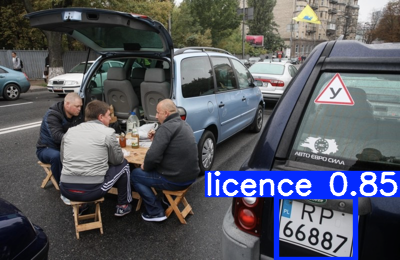

In [3]:
# Step 1: Inference using best.pt on a sample image
from IPython.display import Image, display
import os

# Set paths
weights_path = "/content/yolov5/runs/train/lp-detector/weights/best.pt"
test_image_path = "/content/val/images/Cars125.png"  # Replace with any test image

# Run inference
!python /content/yolov5/detect.py --weights {weights_path} --img 640 --conf 0.25 --source {test_image_path} --save-txt --save-conf --project /content/yolov5/runs/detect --name test-run --exist-ok

# Display result
result_path = "/content/yolov5/runs/detect/test-run/Cars125.png"
display(Image(filename=result_path))


/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2025-7-24 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/c

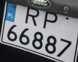

🔤 Detected Plate Text: RP


In [4]:
# Step 2: Extract detected license plate and read text using EasyOCR
import cv2
from PIL import Image
import torch
import easyocr

# Load model
model = torch.hub.load('ultralytics/yolov5', 'custom', path=weights_path, force_reload=True)

# Perform detection
results = model(test_image_path)
boxes = results.xyxy[0]  # x1, y1, x2, y2, conf, class

# Load image
img_cv = cv2.imread(test_image_path)
img_cv_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

if len(boxes) > 0:
    # Take top detection
    x1, y1, x2, y2 = map(int, boxes[0][:4])
    cropped = img_cv_rgb[y1:y2, x1:x2]

    # Save/display cropped region
    cropped_pil = Image.fromarray(cropped)
    display(cropped_pil)

    # OCR
    reader = easyocr.Reader(['en'])
    result = reader.readtext(cropped)
    
    # Display result
    if result:
        print("🔤 Detected Plate Text:", result[0][1])
    else:
        print("❌ OCR Failed to read text")
else:
    print("❌ No license plate detected.")
